In [67]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils
import pickle

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]
plt.rcParams['figure.dpi'] = 300

# For 1 setting (Task exp): ~50k steps per minutes (for each agent process)

N_TASKS = 500 #Actual: 60
N_ARMS = 5
OPT_SIZE = 2 # >1
HORIZON = 200
N_EXPS = 10 #No. of repeat experiments

# N_TASKS = 600 #Actual: 60
# N_ARMS = 150
# OPT_SIZE = 15 # >1
# HORIZON = 8000
# N_EXPS = 10 #No. of repeat experiments

GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD*1.4)
kwargs = {'task_cache_step': 20,
          'gap_constrain':gap,
          'plot_var': True,
          'is_adversarial': True,
          'timeout': 45, # maximum duration for each experiment. Unit = minute. -1 = unlimited
          'quiet': True,
          'skip_list': [],
#           'skip_list': ['PMML'],
          'linewidth': 4,
          'plot_legend': True,
         }
if kwargs['is_adversarial']:
    setting = "Adversarial"
else:
    setting = "Stochastic"
assert N_ARMS<=HORIZON, f"The number of arm ({N_ARMS}) must be smaller than the horizon ({HORIZON})"
assert OPT_SIZE<=N_ARMS, f"The subset size ({OPT_SIZE}) must be smaller than the number of arm ({N_ARMS})"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')

PE_params = 4*np.log(max(np.exp(1), N_ARMS*HORIZON/4))
if N_ARMS*PE_params > HORIZON:
    print(f"WARNING (Phased Elimination): phase 1 duration ({N_ARMS*PE_params}) is larger than the horizon ({HORIZON}) \n=> increase horizon and/or change n_arms.")

GAP_THRESHOLD = 0.39416392841120657, actual gap = 0.5518294997756892


## Regret vs Number of tasks

In [ ]:
task_list = np.arange(200, 1001, 200)
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, HORIZON, N_ARMS, OPT_SIZE, task_list, **kwargs)
pickle.dump(regret_dict, open("results/tasks.p", "wb"))
regret_dict = pickle.load(open("results/tasks.p", "rb"))
pass

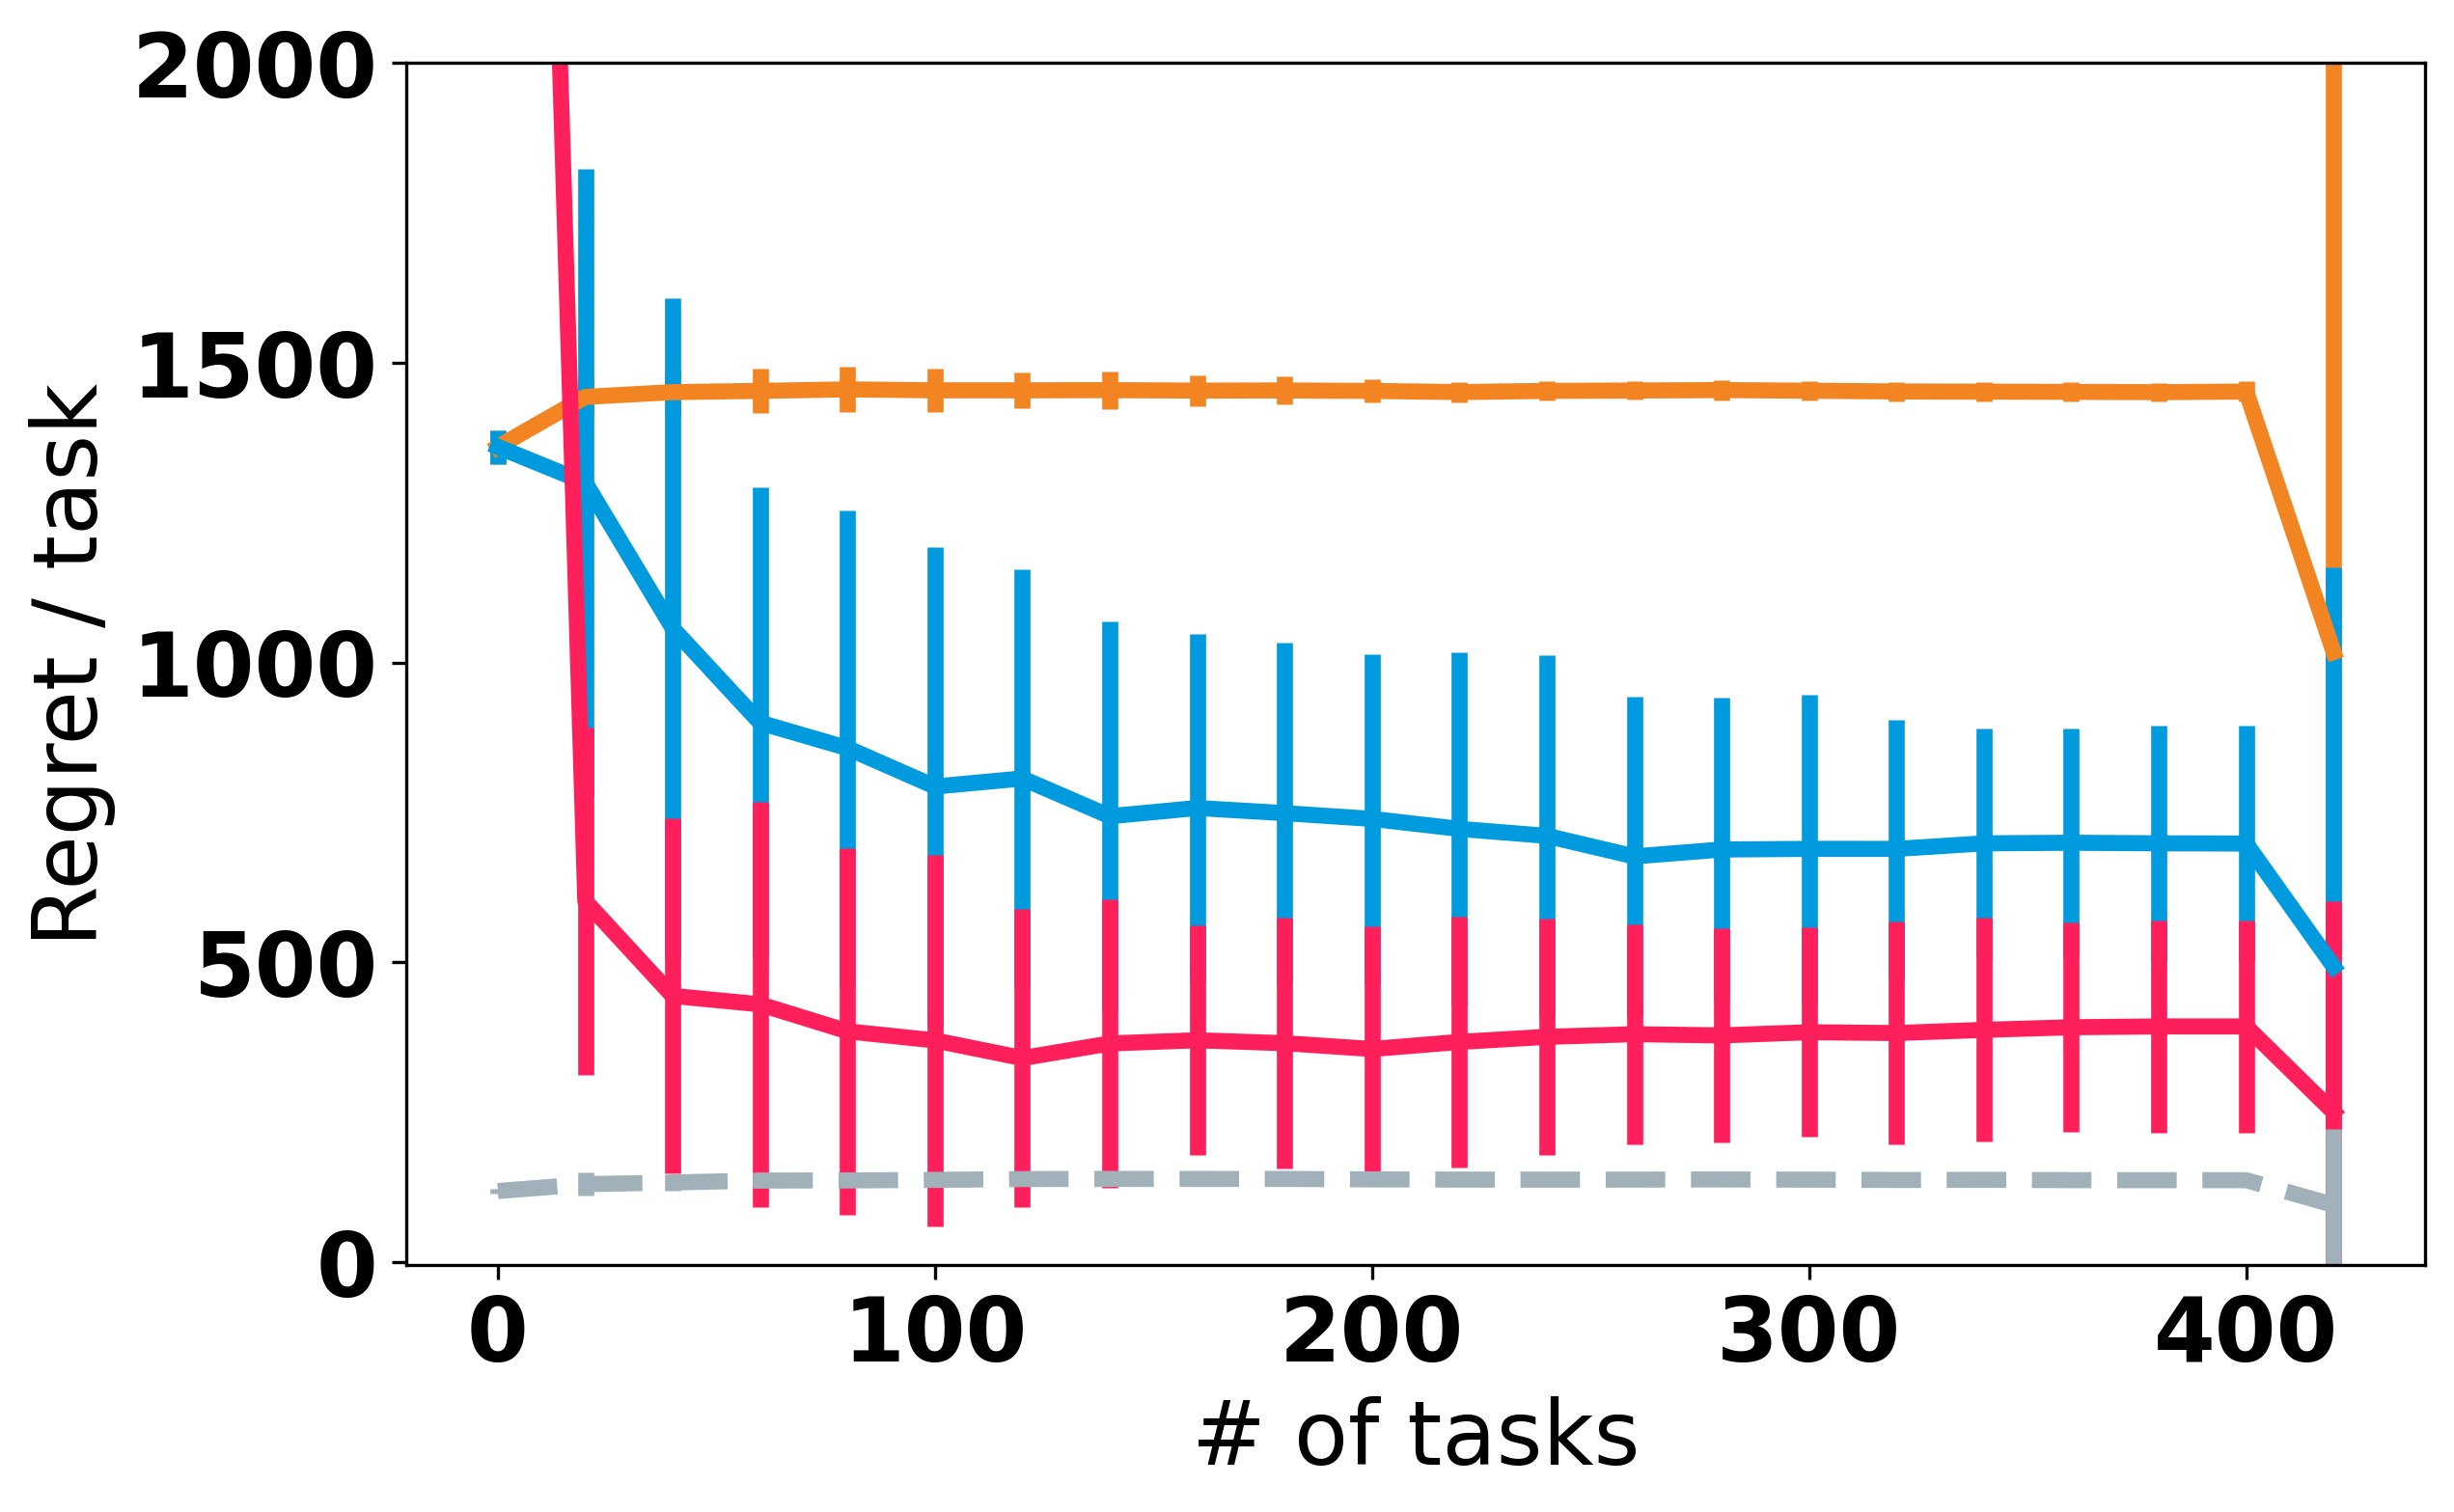

In [61]:
# Plot from loaded cache file
X = np.arange(N_TASKS)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/cache_600_tasks/tasks.p", "rb"))
# regret_dict = pickle.load(open("results/tasks_cache.p", "rb"))
title = ''
# title = f'{setting}:{N_ARMS} arms, horizon = {HORIZON}, and subset size = {OPT_SIZE}'
xlabel, ylabel = '# of tasks', 'Regret / task'
indices = np.arange(0, X.shape[0], kwargs['task_cache_step']).astype(int)
plt.ylim([-5, 2000])
utils.plot(X[indices], regret_dict, title, xlabel, ylabel, **kwargs)
pass

## Regret vs Horizon

100%|██████████| 2/2 [00:00<00:00, 258.60it/s]

opt_indices = [0 2]
opt_indices = [2 4]


opt_indices = [1 2]
opt_indices = [2 3]


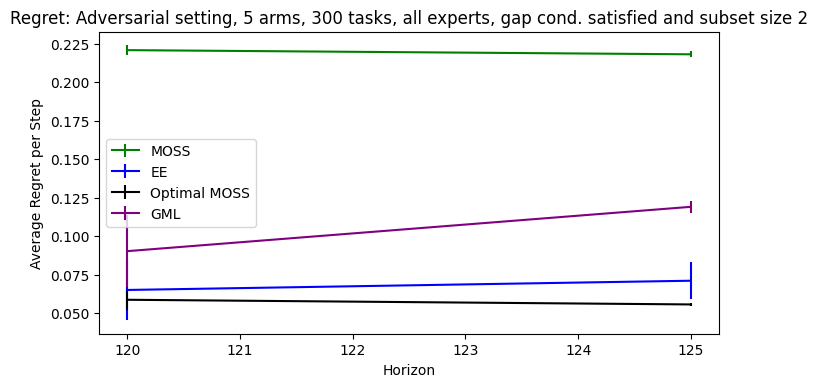

In [3]:
horizon_list = np.arange(120, 126, 5)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
pass

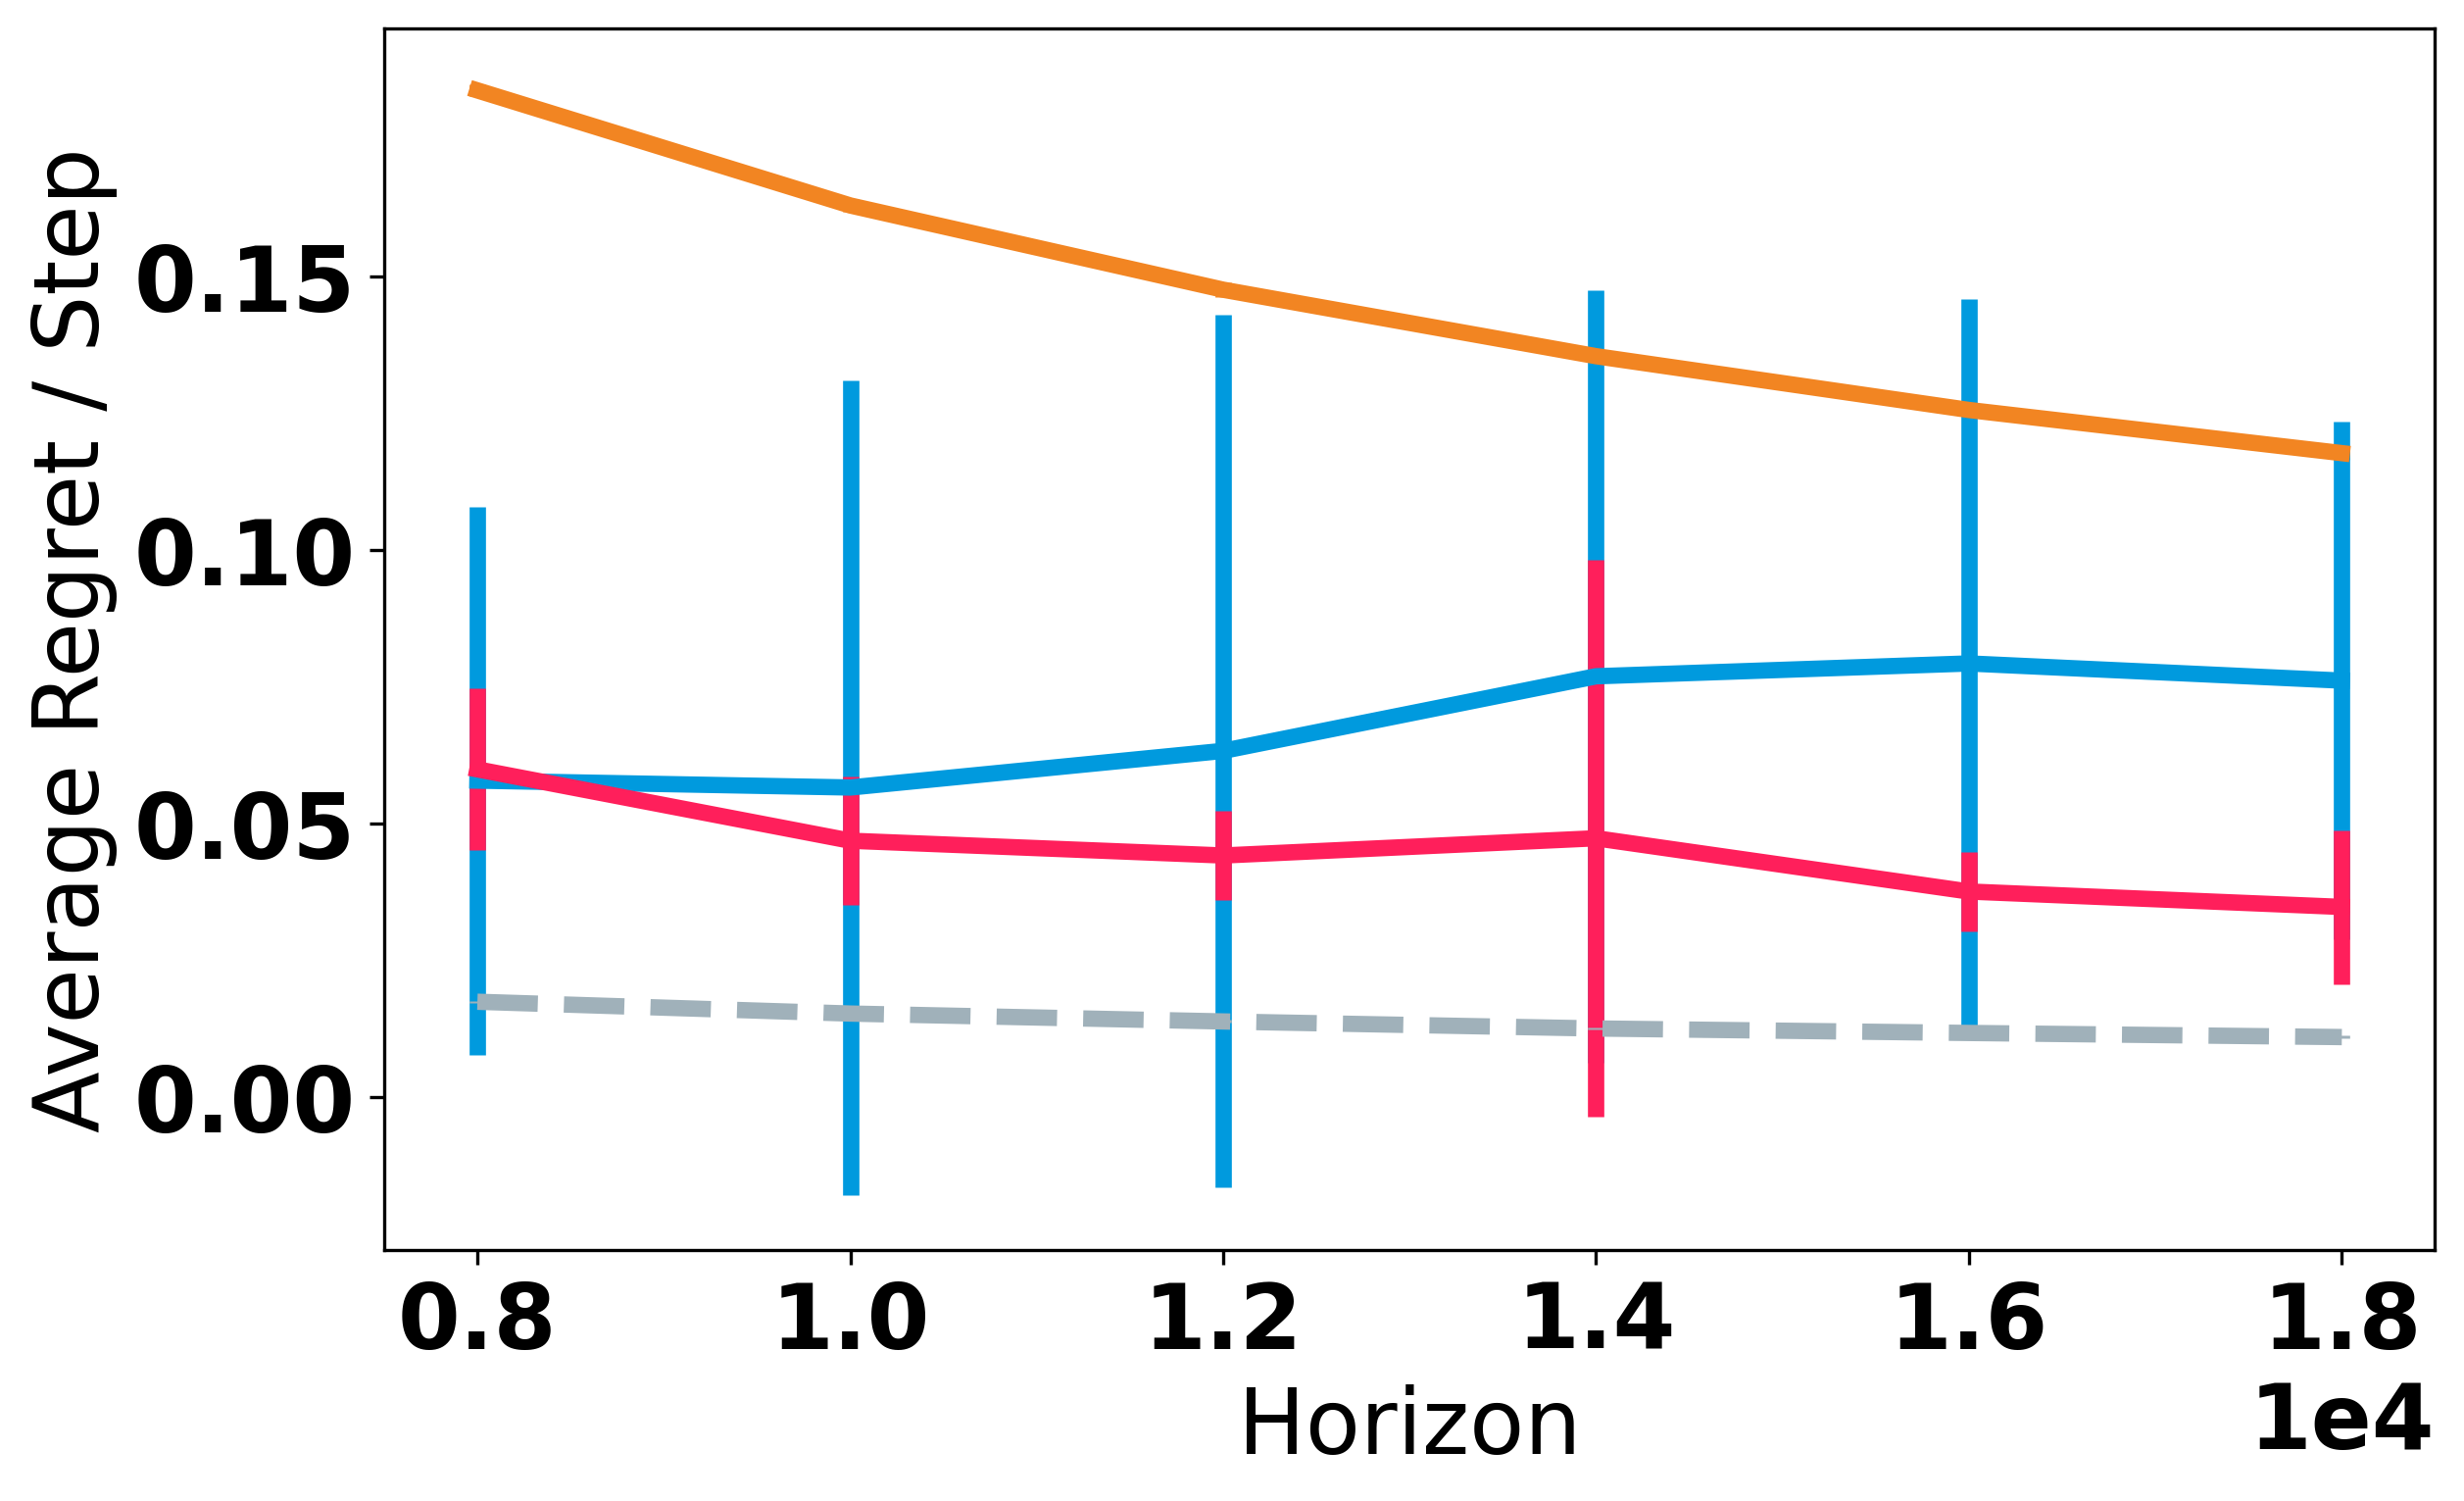

In [62]:
# Plot from loaded cache file
# X_h = np.arange(120, 260, 25) # small
# X_h = np.arange(270, 440, 50) # small stochastic
X_h = np.arange(8000, 20010, 2000)
regret_dict_h = pickle.load(open("results/cache_600_tasks/horizon.p", "rb"))
title = ''
# title = f'{setting}: {N_ARMS} arms, {N_TASKS} tasks, and subset size = {OPT_SIZE}'
xlabel, ylabel = 'Horizon', 'Average Regret / Step'
# plt.ylim([0, 0.3])
utils.plot(X_h, regret_dict_h, title, xlabel, ylabel, **kwargs)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Regret vs # of arm

100%|██████████| 2/2 [00:00<00:00, 251.80it/s]

opt_indices = [0 1]
opt_indices = [1 2]


opt_indices = [1 3]
opt_indices = [2 3]
opt_indices = [1 4]
opt_indices = [1 4]
opt_indices = [1 3]
opt_indices = [1 4]
opt_indices = [2 4]
WARNING (Phased Elimination): phase 1 duration (154) is larger than the horizon (150) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (154) is larger than the horizon (150) => increase horizon and/or change n_arms.
opt_indices = [1 3]
WARNING (Phased Elimination): phase 1 duration (154) is larger than the horizon (150) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (154) is larger than the horizon (150) => increase horizon and/or change n_arms.


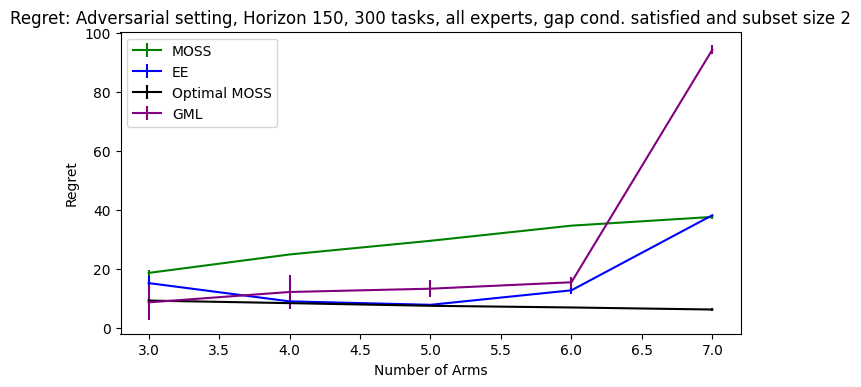

In [2]:
n_arms_list = np.arange(3,8,1)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, HORIZON, OPT_SIZE, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
regret_dict_h = pickle.load(open("results/arms.p", "rb"))
pass

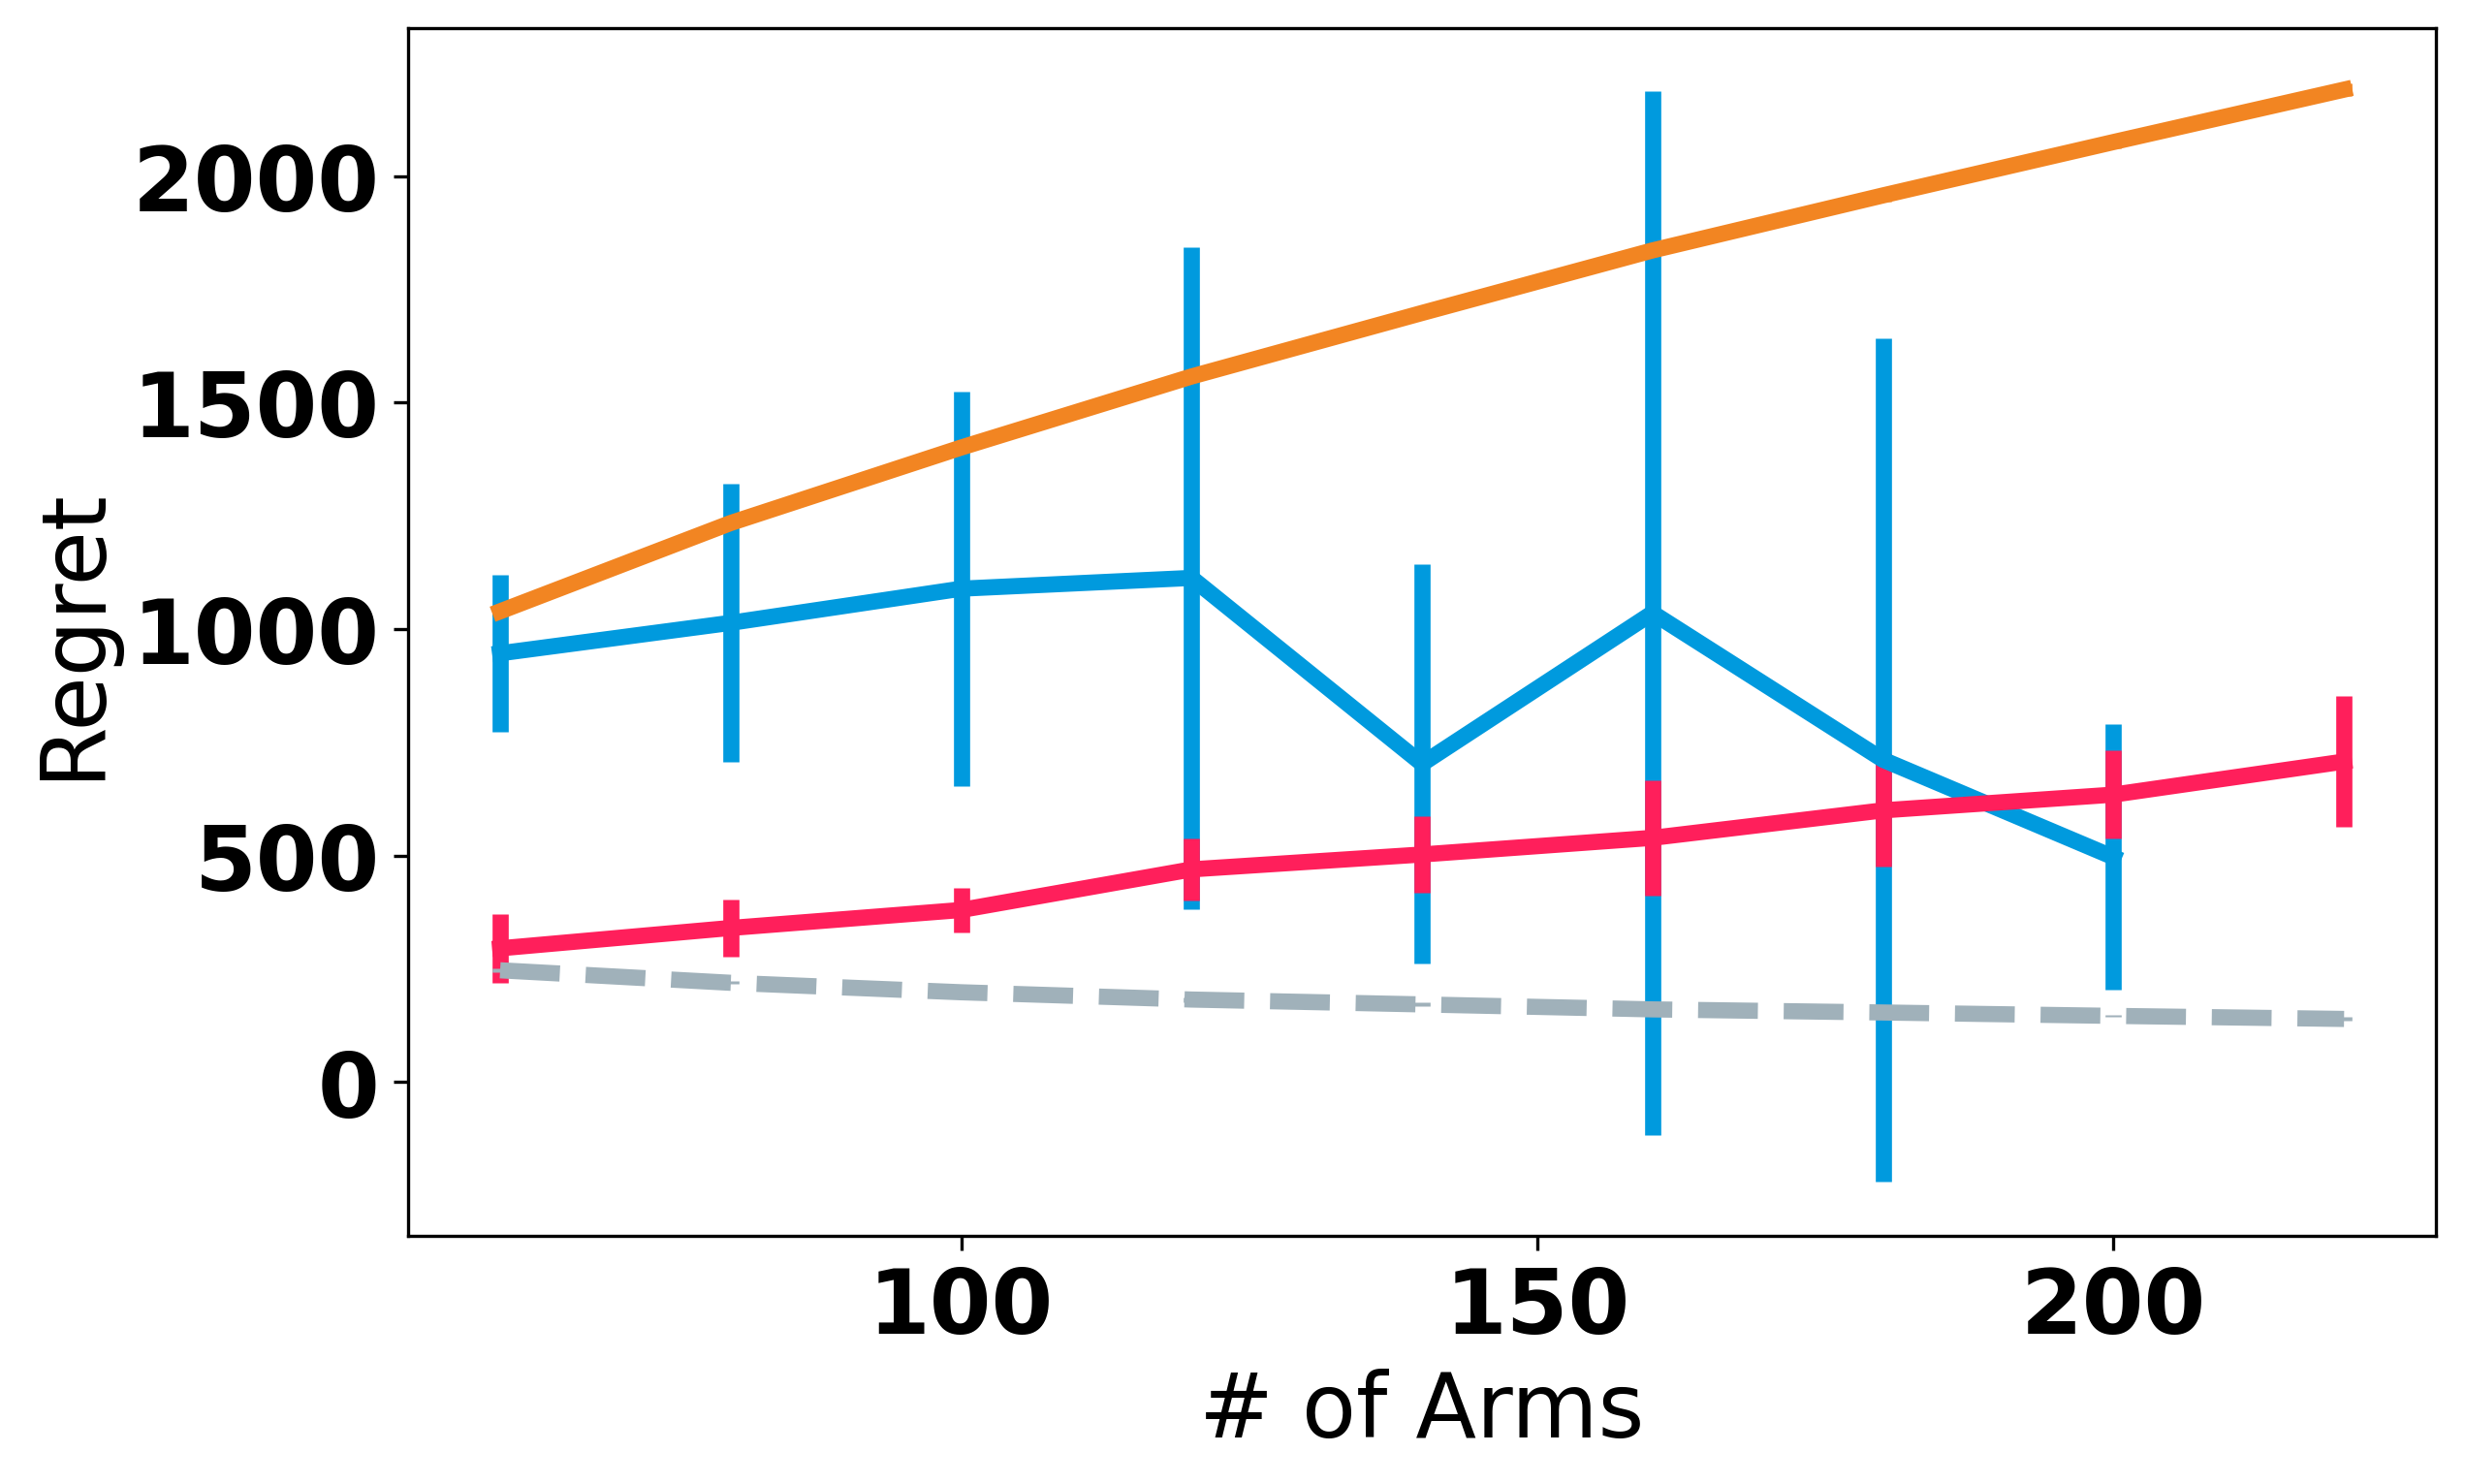

In [63]:
# Plot from loaded cache file
# HORIZON = 12000
X_b = np.arange(60,221,20)
# X_b = np.arange(3,8,1) # small
# title = f'{setting}: Horizon = {HORIZON}, {N_TASKS} tasks, and subset size = {OPT_SIZE}'
title = ''
xlabel, ylabel = '# of Arms', 'Regret'
regret_dict_b = pickle.load(open("results/cache_600_tasks/arms.p", "rb"))
# plt.ylim([-5, 55])
utils.plot(X_b, regret_dict_b, title, xlabel, ylabel, **kwargs)

## Regret vs subset size

100%|██████████| 2/2 [00:00<00:00, 271.17it/s]

opt_indices = [0 4]
opt_indices = [1 3]


opt_indices = [0 1 2 4]
opt_indices = [0 1 2 4]


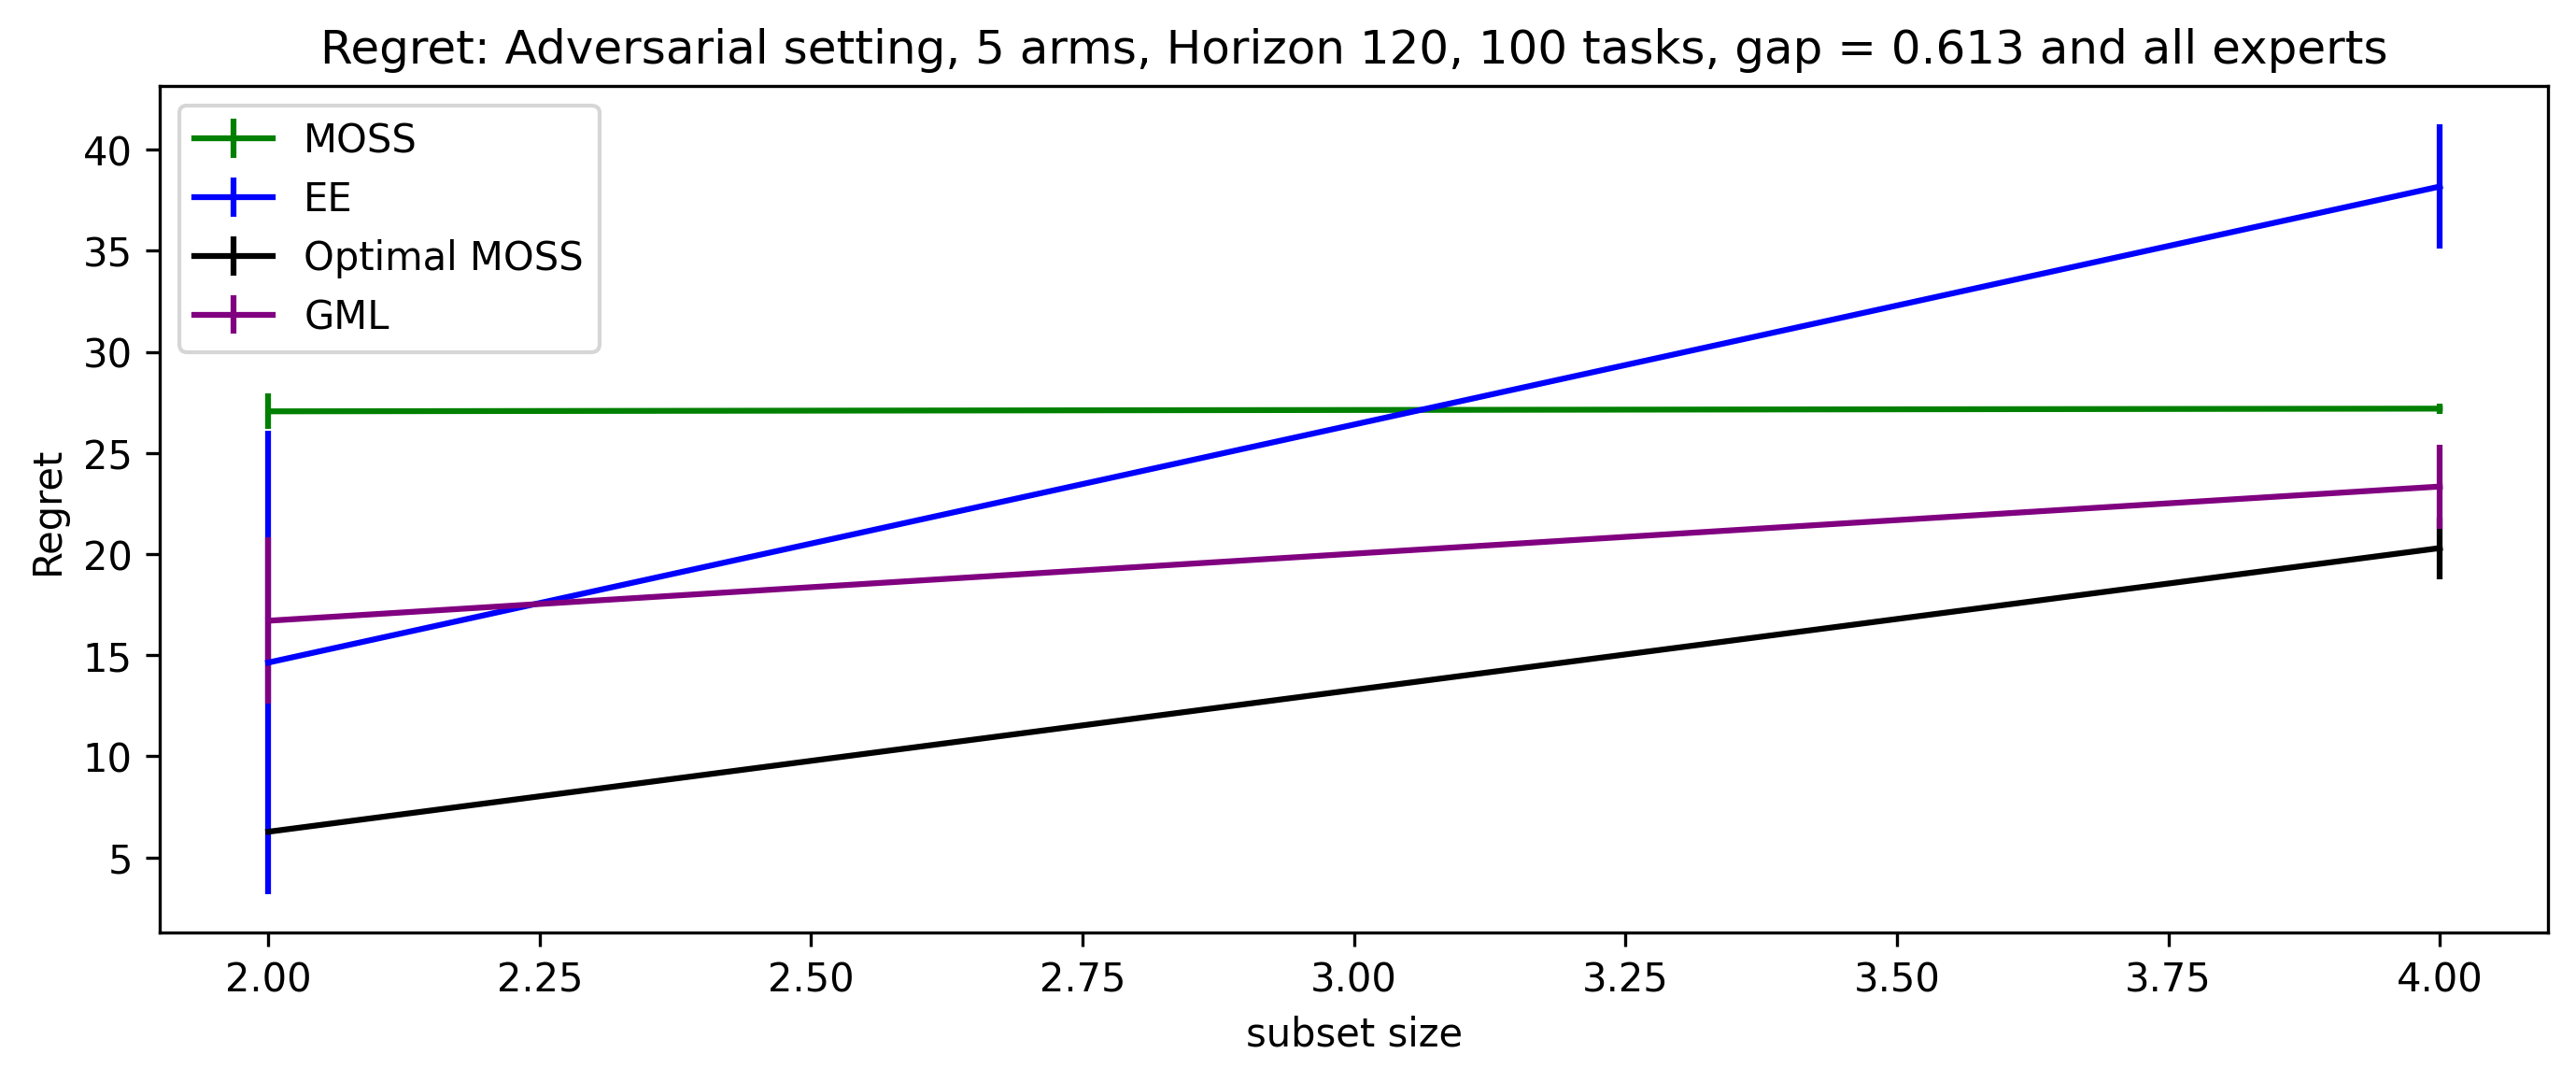

In [52]:
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = np.arange(1,N_ARMS+1,1), **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
regret_dict_h = pickle.load(open("results/subset.p", "rb"))
pass

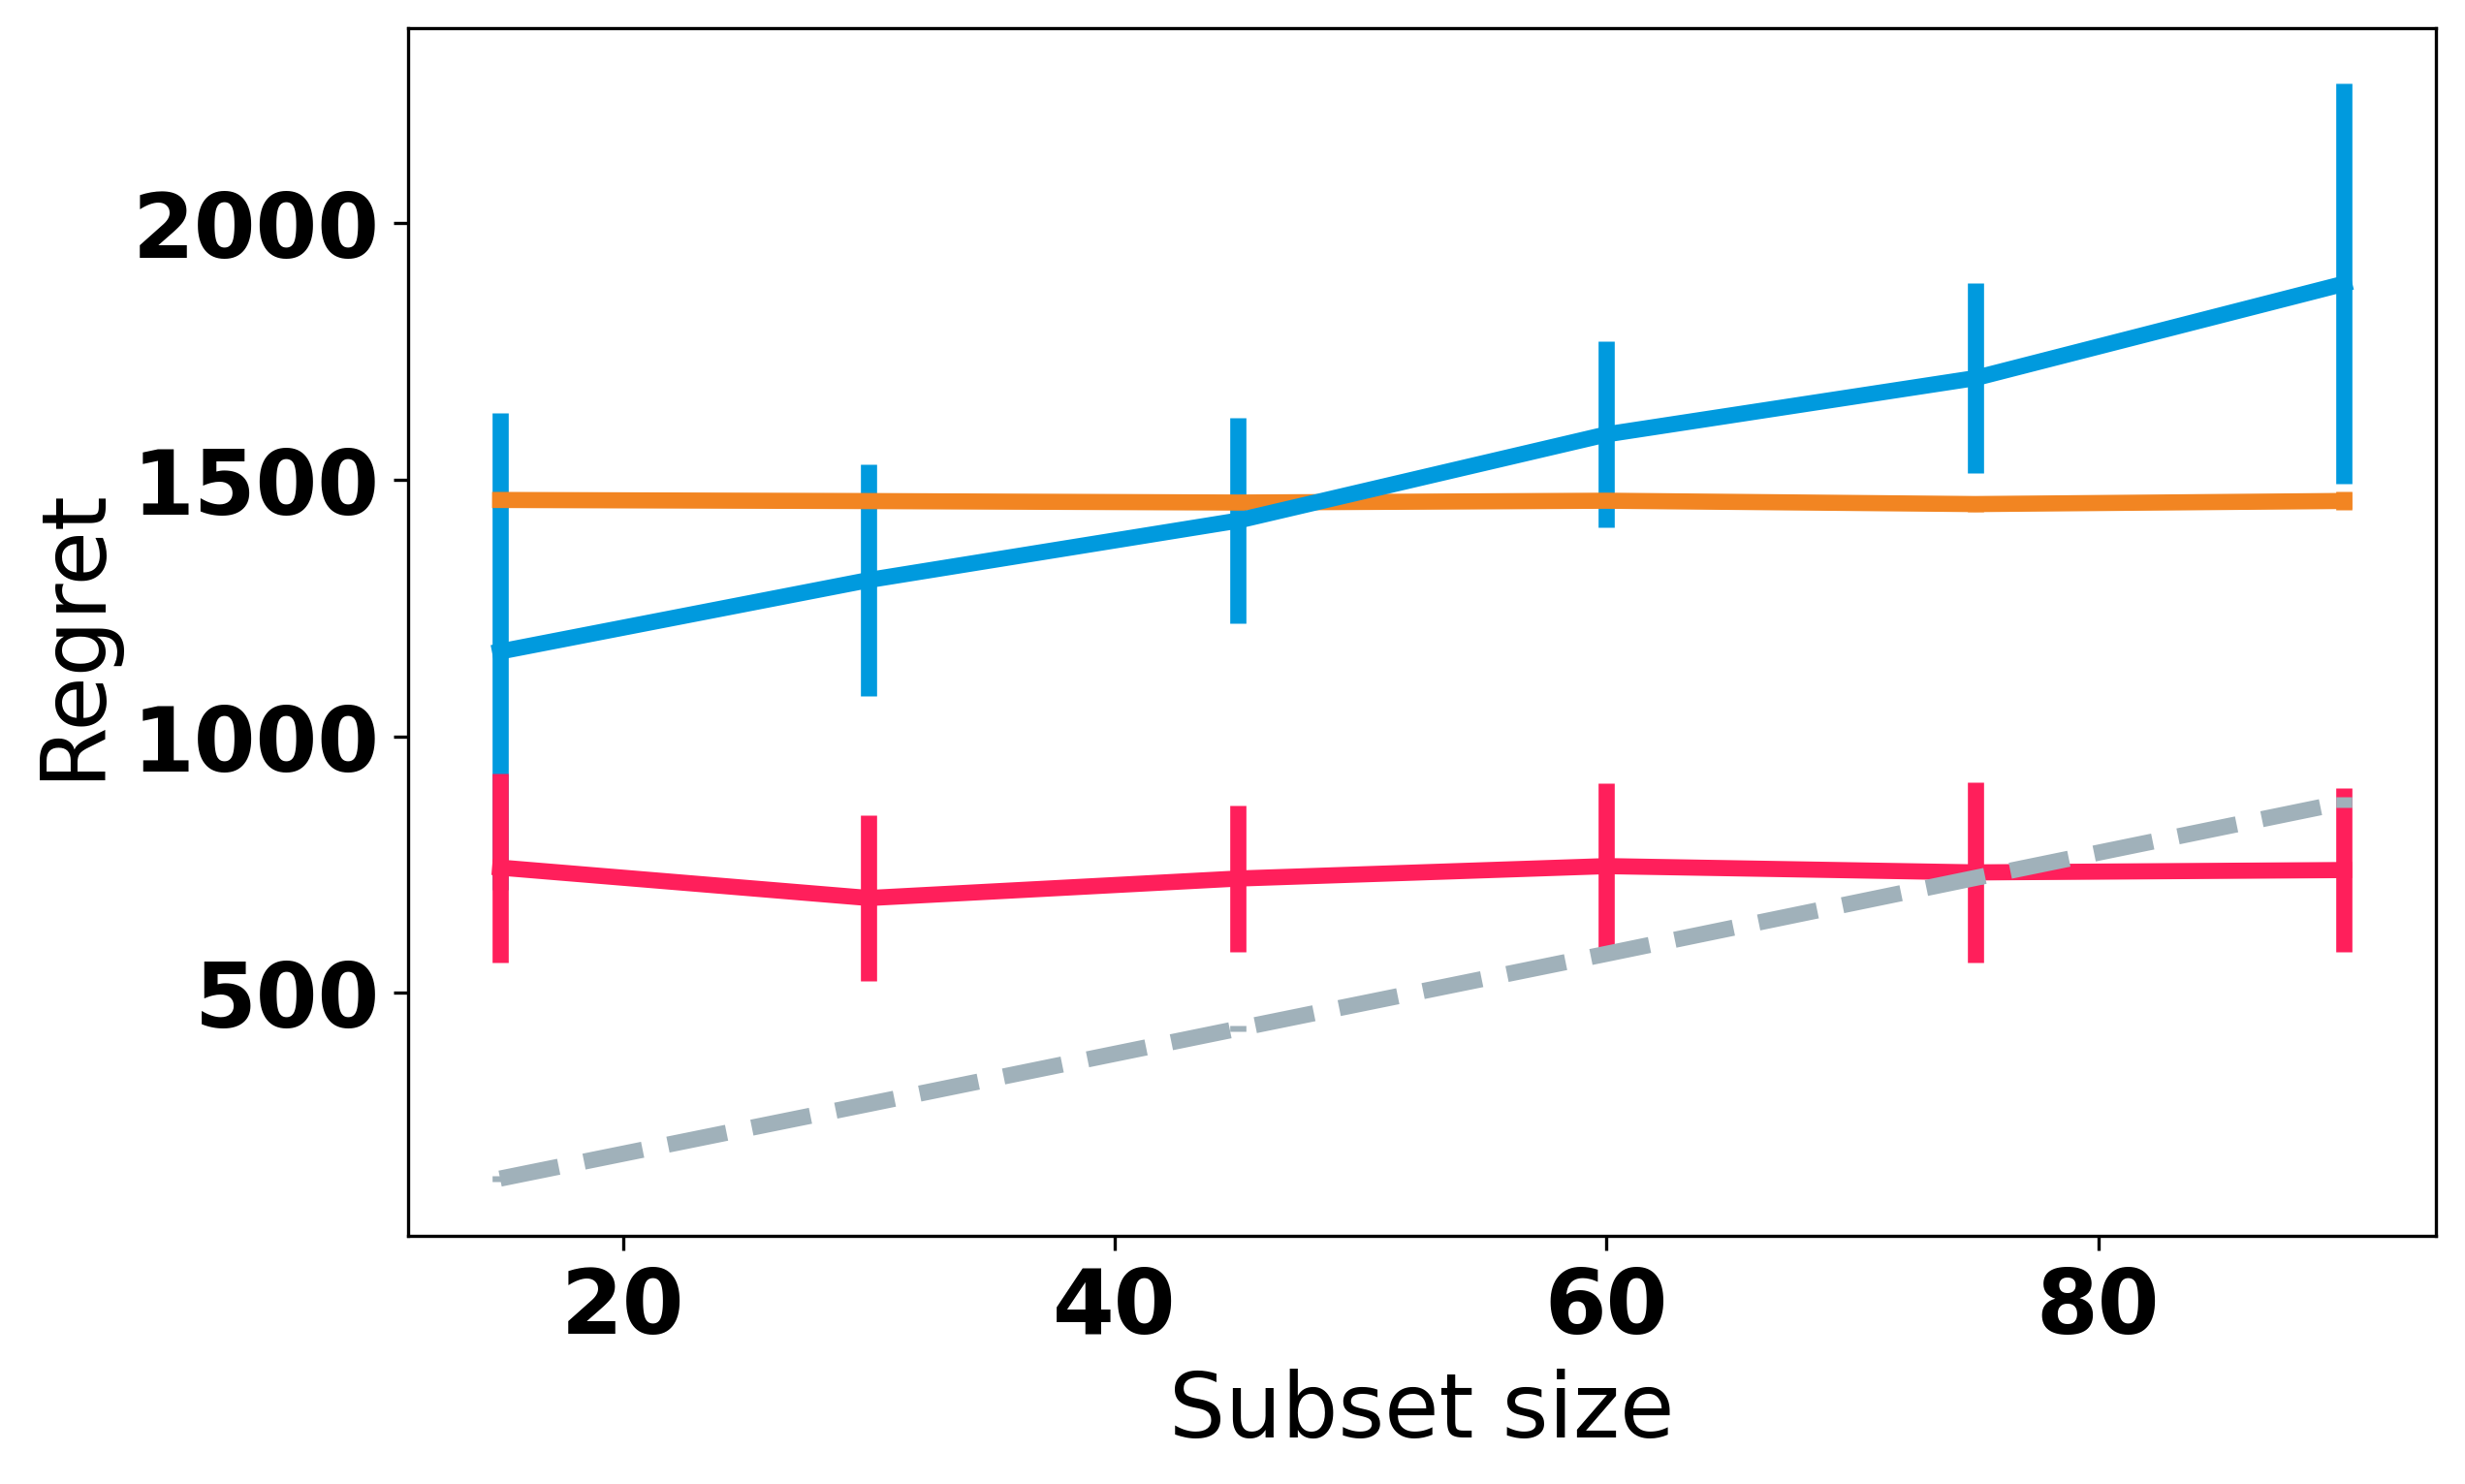

In [64]:
# Plot from loaded cache file
# title=f'{setting}: {N_ARMS} arms, horizon = {HORIZON}, {N_TASKS} tasks'
title = ''
xlabel, ylabel = 'Subset size', 'Regret'
# X_e = np.arange(2,6,1)
X_e = np.arange(15,91,15)
regret_dict_e = pickle.load(open("results/cache_600_tasks/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, title, xlabel, ylabel, **kwargs)

# Plotting legend code

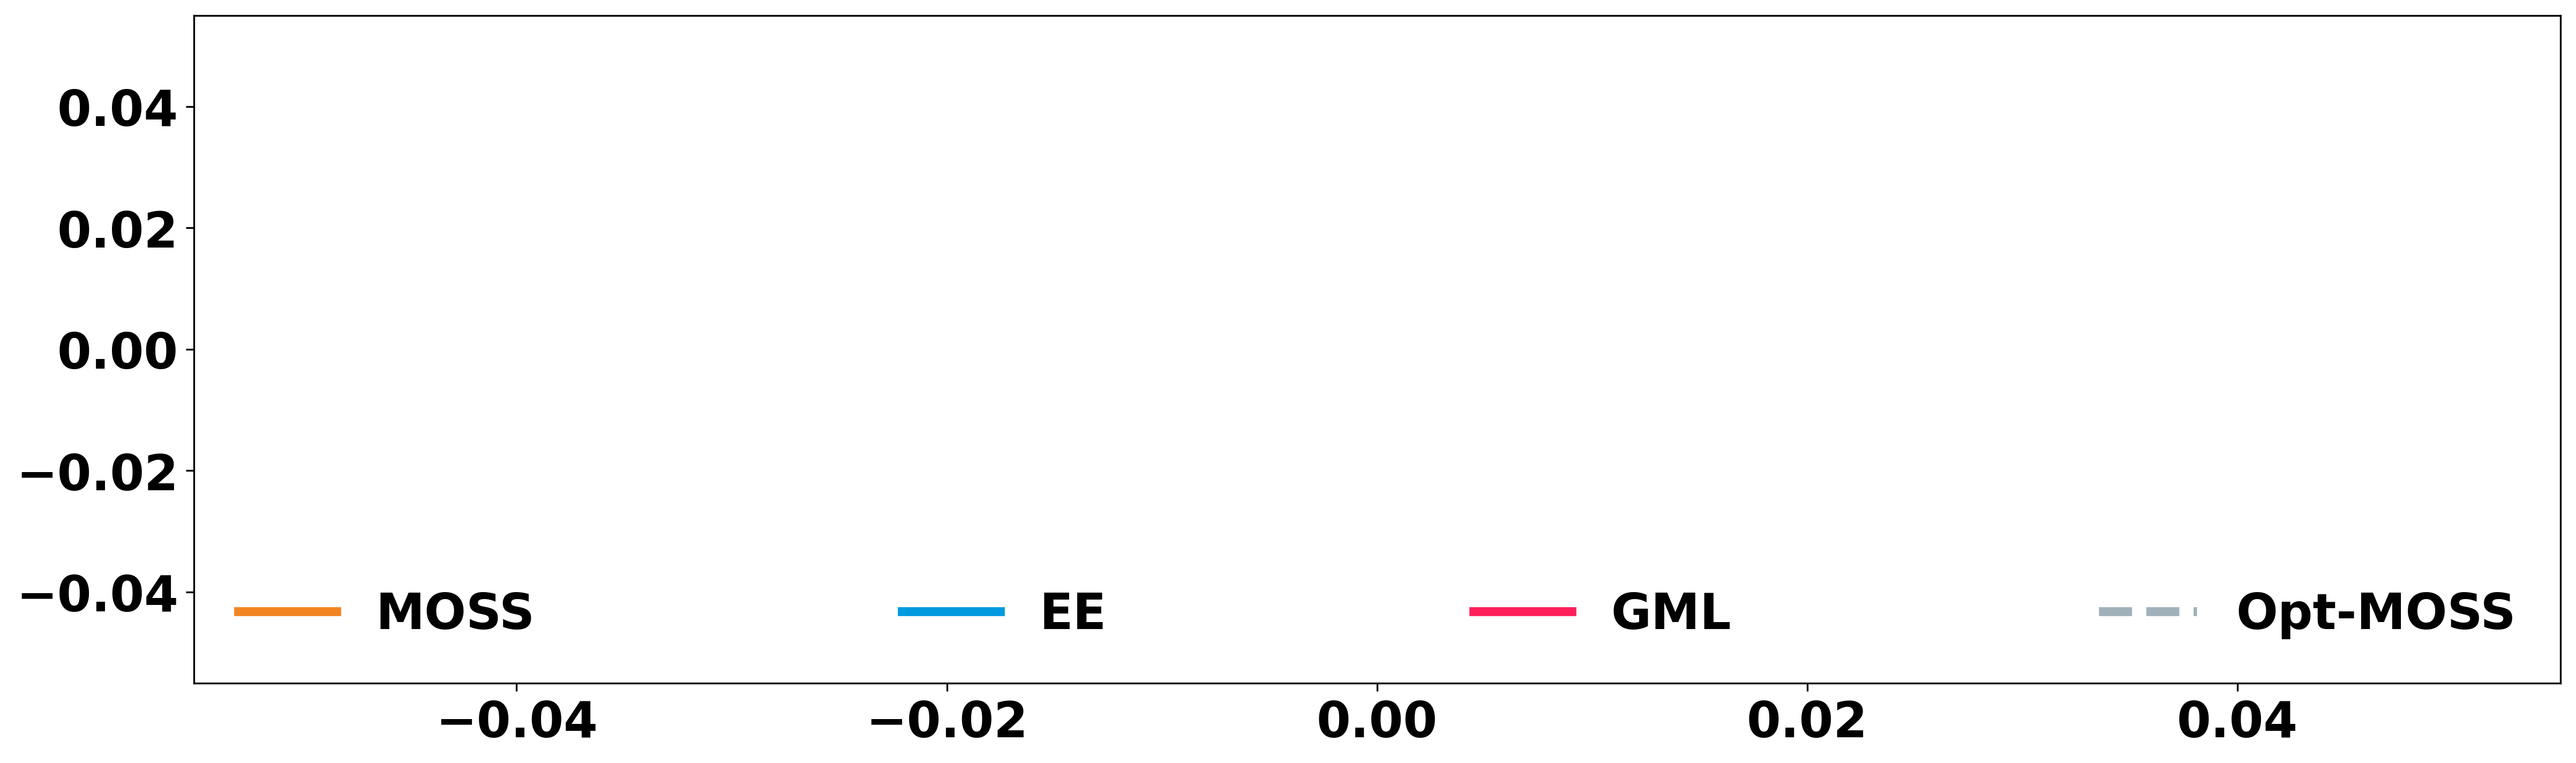

In [6]:
labels = ["MOSS", "EE", "GML", "Opt-MOSS"]
# labels = ["MOSS", "EE", "GML", "PMML", "Opt-MOSS"]
colors = ["#F28522", "#009ADE", "#FF1F5B", "#A0B1BA"]
# colors = ["#F28522", "#009ADE", "#FF1F5B", "#00CD6C", "#A0B1BA"]
linestyles = ["-", "-", "-", "dashed"]
# linestyles = ["-", "-", "-", "-", "dashed"]
f = lambda c,l: plt.plot([],[], color=c, ls=l, linewidth=4)[0]
handles = [f(colors[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, mode="expand", ncol=len(handles))

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()